#library

In [1]:
import pandas as pd
from pandas.core.frame import DataFrame
import numpy as np
import requests
import regex as re
import random
import nltk
from nltk.corpus import gutenberg,stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn import feature_extraction, manifold
from sklearn import decomposition
import gensim
import gensim.downloader as gensim_api
from gensim.corpora import Dictionary
import warnings
warnings.filterwarnings(action='once')
from sklearn.manifold import TSNE

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
#word ebbedding dictionnary, takes about 1-4 mins(376 MB)
nlp = gensim_api.load("glove-wiki-gigaword-100") 

[==================================================] 100.0% 128.1/128.1MB downloaded


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


### Data Partitioning

#### ```partition()``` Devides the words list into 200 samples of 150 words each 

In [4]:
def partition(words, book_label):
  n = len(words) // 150  # How many 150-word partitions are there?
  partitions =[]
  i = 0

  # Loop over the words to store each 150-word partition in a list inside partitions list
  while i < n:
    current = i*150
    partitions.append([words[current:current+150], book_label])
    i+=1


  # return a dataframe of 200 samples
  return DataFrame(partitions[:200], columns = ['words', 'Book_name'])


In [5]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

####``` data_preperation ``` returns a clean list of words from a single book







In [6]:
stop_words = stopwords.words('english')
def data_preperation (url):
  #Getting data
  response = requests.get(url)
  text =response.text.lower()


  #Data cleansing:
  text = re.sub('[^a-z]+', ' ', text)

  # p = re.compile(r'\W+')
  # words = p.split(text)

  #Part of spech:
  pos_tagged = nltk.pos_tag(nltk.word_tokenize(text)) 
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

  lemmatizer  = WordNetLemmatizer()
  #lemmatized = [lemmatizer.lemmatize(wrd[0], pos =  wrd[1]) for wrd in wordnet_tagged if wrd[1]!=None and wrd not in stop_words]
  lemmatized_words = []
  for wrd in wordnet_tagged:
     #loop over the words and thier part of spech to lemmatize them
    if wrd[1]!= None and wrd[0] not in stop_words :
      if wrd[0][-3:] == 'ing': #to lemmatize a word even if it's a noun
        pos = 'v'
      else:
        pos =  wrd[1]
      #final = lemmatizer.lemmatize(wrd[0], pos =  pos)
      if lemmatizer.lemmatize(wrd[0], pos =  pos) in nlp.vocab.keys():
        lemmatized_words.append(lemmatizer.lemmatize(wrd[0], pos =  pos))

  # Pass the words, ignoring the first 500 to avoid introductions.. 
  return lemmatized_words[500:]

#### ``` Data_generator ```

In [7]:
def Data_generator(urls=['https://www.gutenberg.org/files/68054/68054-0.txt'], labelels = ["a"]):
  # a dataframe to store samples from all of the books
  big_frame = DataFrame() 

  for url, label in zip(urls, labelels):
    words = data_preperation(url) #returns a list of words from a single book
    x = partition(words, label) # Devides the words list into 200 samples of 100 words each
    big_frame =pd.concat([big_frame, x]) # Append book samples to the big dataframe


  return big_frame

# ``` main ```  
Passes two lists of books urls & labels to ```Data_generator```

In [8]:
#if __name__ == "__main__":
# urls = ['https://www.gutenberg.org/cache/epub/18350/pg18350.txt', #1)Social Life in the Insect World, Author: J. H. Fabre
#         'https://www.gutenberg.org/cache/epub/18931/pg18931.txt',  #2)Archeological Investigations, Author: Gerard Fowke
#         'https://www.gutenberg.org/cache/epub/13058/pg13058.txt',   #3)The Teeth of the Tiger, Author: Maurice Leblanc
#         'https://www.gutenberg.org/cache/epub/28056/pg28056.txt', #4)Music and Some Highly Musical People, Author: James M. Trotter
#         'https://www.gutenberg.org/cache/epub/21687/pg21687.txt', #)The Youngest Girl in the Fifth, Author: Angela Brazil
#         ]
urls = ['https://www.gutenberg.org/files/17321/17321-0.txt', #1)Social Life in the Insect World, Author: J. H. Fabre
        'https://www.gutenberg.org/cache/epub/22775/pg22775.txt',  #2)Archeological Investigations, Author: Gerard Fowke
        'https://www.gutenberg.org/cache/epub/10136/pg10136.txt',   #3)The Teeth of the Tiger, Author: Maurice Leblanc
        'https://www.gutenberg.org/cache/epub/28056/pg28056.txt', #4)Music and Some Highly Musical People, Author: James M. Trotter
        'https://www.gutenberg.org/cache/epub/51854/pg51854.txt', #)The Youngest Girl in the Fifth, Author: Angela Brazil
        ]
labelels = ["a", "b", "c", "d", "e"]

df = Data_generator(urls, labelels).sample(frac=1).reset_index(drop=True)

In [9]:
df

,words,Book_name
0,"[tender, surprise, lip, time, great, writer, e...",d
1,"[do, respect, member, probe, see, do, drain, s...",c
2,"[red, hair, germaine, dozen, perhaps, get, bac...",e
3,"[visual, image, woman, raise, glass, poison, m...",b
4,"[wield, supreme, authority, governor, independ...",a
...,...,...
995,"[resort, low, subterfuge, instead, broker, bib...",e
996,"[exactly, degree, reach, advice, give, nothing...",b
997,"[language, moreover, archaic, form, character,...",a
998,"[aise, french, mode, dress, green, colour, dis...",c


#Data Transformers

### BOW

In [10]:
paragraph=" "
paragraph_list=[]
for x in df['words']:
    paragraph=paragraph.join(x) 
    paragraph_list.append(paragraph)
    paragraph=" "
#paragraph_list =paragraph_list + paragraph_list
len(paragraph_list)

1000

In [11]:
def BOW(sentences_book):
  count_vect = CountVectorizer()
  X_train_counts = count_vect.fit_transform(sentences_book).toarray()
  
  return X_train_counts

###TF-IDF

In [12]:
def TF_IDF(X_train_counts):
  tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
  X_train_tf = tf_transformer.transform(X_train_counts).toarray()
  
  return X_train_tf

###LDA

In [13]:
dictionary = Dictionary(df['words'])
bow_ = [dictionary.doc2bow(partition) for partition in df['words']]  # bag of words for each partition
example = pd.DataFrame(bow_[10], columns=["token_id", "frequency"])

def lda_training(n_topics, dictionary):
  lda_model = gensim.models.LdaModel(bow_,
               id2word = dictionary,
               num_topics = n_topics,
               random_state = 100,
               passes = 50,
               iterations = 500, 
               chunksize = 100
               )
  coherence_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=df['words'], dictionary=dictionary , coherence='c_v')
  coherence_lda = coherence_lda.get_coherence()
  print('\nCoherence Score: ', coherence_lda)
  print(lda_model.print_topics())
  return lda_model

In [14]:
lda1 = lda_training(n_topics = 10,dictionary = dictionary)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)



Coherence Score:  0.5843095290000846
[(0, '0.022*"god" + 0.020*"music" + 0.016*"great" + 0.013*"pyramid" + 0.011*"art" + 0.009*"temple" + 0.008*"gudea" + 0.007*"greenfield" + 0.006*"tom" + 0.005*"sun"'), (1, '0.015*"mental" + 0.014*"idea" + 0.013*"life" + 0.011*"mind" + 0.011*"brain" + 0.009*"thus" + 0.009*"influence" + 0.008*"suggestion" + 0.008*"mean" + 0.008*"experience"'), (2, '0.024*"king" + 0.020*"dynasty" + 0.014*"early" + 0.013*"name" + 0.012*"egyptian" + 0.012*"find" + 0.012*"period" + 0.011*"egypt" + 0.010*"city" + 0.008*"temple"'), (3, '0.012*"mr" + 0.010*"music" + 0.009*"give" + 0.009*"say" + 0.009*"miss" + 0.008*"musical" + 0.008*"voice" + 0.007*"even" + 0.006*"sing" + 0.006*"new"'), (4, '0.015*"time" + 0.011*"first" + 0.009*"find" + 0.008*"much" + 0.007*"work" + 0.007*"great" + 0.007*"use" + 0.007*"many" + 0.006*"make" + 0.006*"also"'), (5, '0.026*"say" + 0.024*"tell" + 0.018*"get" + 0.015*"know" + 0.014*"go" + 0.014*"tompkins" + 0.012*"mr" + 0.011*"ask" + 0.010*"see" + 

In [15]:
def feature_vectorize(lda):

  # Convert target column from string to numbers 
  df.Book_name = pd.Categorical(df.Book_name)
  df['Book_name'] = df.Book_name.cat.codes

  
  train_vecs = []
  for i in range(len(df['words'])):
    top_topics = lda.get_document_topics(bow_[i], minimum_probability = 0.0)
    topic_vec = [top_topics[i][1] for i in range(len(lda.print_topics()))]
    train_vecs.append(topic_vec)

  features = pd.DataFrame(train_vecs)
  lda_data = features.join(df["Book_name"])#.sample(frac = 1)

  lda_x = lda_data[lda_data.columns[:-1]]
  lda_y = pd.DataFrame(lda_data[lda_data.columns[-1]])
  return lda_data, lda_x, lda_y

###Word Embedding

In [16]:
def word_embidding():
  reduction = []
  for i in range(0, 1000):
    #transform each word to a vec
    doc2vec = nlp[df['words'].iloc[i]]

    #reduce the dimensions from 300 to 2
    pca = decomposition.PCA(n_components=50)
    reduction.append(doc2vec)

  we_array = np.array(reduction).reshape(1000, 100*150)  
  return pd.DataFrame(we_array)

## Implement transformations 

In [17]:
X_train_counts= BOW(paragraph_list)
X_train_tf= TF_IDF(X_train_counts)
# x_train_ngram=Ngram(paragraph_list)
lda_data, lda_x, lda_y = feature_vectorize(lda1)
X_train_we = word_embidding()

In [18]:
lda_x

,0,1,2,3,4,5,6,7,8,9
0,0.169733,0.251762,0.011634,0.297525,0.216487,0.000662,0.008371,0.042501,0.000662,0.000662
1,0.000662,0.000662,0.000662,0.015121,0.055615,0.000662,0.000662,0.000662,0.000662,0.924628
2,0.000662,0.048710,0.352769,0.098858,0.097473,0.342730,0.000662,0.056811,0.000662,0.000662
3,0.000662,0.412373,0.000662,0.024870,0.157921,0.000662,0.308322,0.061113,0.000662,0.032750
4,0.000662,0.126147,0.784110,0.022573,0.052625,0.000662,0.000662,0.000662,0.011233,0.000662
...,...,...,...,...,...,...,...,...,...,...
995,0.022215,0.000662,0.105474,0.236268,0.107876,0.421684,0.027270,0.068999,0.008890,0.000662
996,0.015917,0.559298,0.019578,0.081398,0.122028,0.089207,0.017978,0.086367,0.007567,0.000662
997,0.015177,0.099316,0.417685,0.062594,0.289632,0.039744,0.000662,0.018364,0.046143,0.010684
998,0.007472,0.000662,0.000662,0.007808,0.043906,0.046653,0.007671,0.000662,0.651174,0.233329


In [19]:
lda_x

,0,1,2,3,4,5,6,7,8,9
0,0.169733,0.251762,0.011634,0.297525,0.216487,0.000662,0.008371,0.042501,0.000662,0.000662
1,0.000662,0.000662,0.000662,0.015121,0.055615,0.000662,0.000662,0.000662,0.000662,0.924628
2,0.000662,0.048710,0.352769,0.098858,0.097473,0.342730,0.000662,0.056811,0.000662,0.000662
3,0.000662,0.412373,0.000662,0.024870,0.157921,0.000662,0.308322,0.061113,0.000662,0.032750
4,0.000662,0.126147,0.784110,0.022573,0.052625,0.000662,0.000662,0.000662,0.011233,0.000662
...,...,...,...,...,...,...,...,...,...,...
995,0.022215,0.000662,0.105474,0.236268,0.107876,0.421684,0.027270,0.068999,0.008890,0.000662
996,0.015917,0.559298,0.019578,0.081398,0.122028,0.089207,0.017978,0.086367,0.007567,0.000662
997,0.015177,0.099316,0.417685,0.062594,0.289632,0.039744,0.000662,0.018364,0.046143,0.010684
998,0.007472,0.000662,0.000662,0.007808,0.043906,0.046653,0.007671,0.000662,0.651174,0.233329


#Models

##Imports

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from IPython.display import clear_output
from sklearn.metrics import cohen_kappa_score
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics.cluster import homogeneity_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import GenericUnivariateSelect, chi2

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [21]:
def selection(x,y):
  transformer = GenericUnivariateSelect(chi2, mode='k_best', param=1000)
  return transformer.fit_transform(x,y)

In [22]:
def change_scaling(feature_data):

  scaler = MinMaxScaler()
  scaler.fit(feature_data)
  new_data=scaler.transform(feature_data)
  return new_data

In [23]:
#determine optimal number of clusters
def get_no_clusters(feature_data):
  wcss = []
  for i in range(1, 11):
      kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
      kmeans.fit(feature_data)
      wcss.append(kmeans.inertia_)
      
  plt.plot(range(1, 11), wcss)
  plt.title('Elbow Method')
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.show()
  
  s = []
  for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(feature_data)
    s.append(silhouette_score(feature_data, kmeans.labels_))

  plt.plot(range(2, 11), s)
  plt.xlabel('Number of clusters')
  plt.ylabel('silhouette')
  plt.show()
  clear_output

  plt.bar(range(2, 11), s)
  plt.xlabel('Number of Clusters')
  plt.ylabel('V-Measure Score')
  plt.title('Comparison of different Clustering Models')
  plt.show()

In [24]:
def k_mean_model(feature_data,k):

  #apply k_means
  kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=30, random_state=100)
  model=kmeans.fit(feature_data)
  pred_y = kmeans.predict(feature_data)
  return pred_y,model

In [25]:
def plot_kmeans(feature_data,title):
  
  #PCA
  pca = PCA(n_components=2)
  new_feature=pca.fit_transform(feature_data)

  kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=100)
  model=kmeans.fit(new_feature)
  pred_y = kmeans.predict(new_feature)

  #build dataframe
  new_df=pd.DataFrame()
  x_list=[]
  y_list=[]
  for i in new_feature:
    x_list.append(i[0])
    y_list.append(i[1])

  new_df['x']=pd.DataFrame(x_list)
  new_df['y']=pd.DataFrame(y_list)
  new_df['label']=pd.DataFrame(pred_y)
  
  #plot_seaborn
  sns.scatterplot(data=new_df,x=new_df.iloc[:,0],y=new_df.iloc[:,1],s=120,hue=new_df['label'])
  plt.title(f'K_MEAN WITH {title}')
  sns.scatterplot(x=kmeans.cluster_centers_[:, 0],y=kmeans.cluster_centers_[:, 1],s=150,color='y')
  

In [26]:
def compare_target(y_pred):

  compare_df = pd.concat([df, pd.DataFrame(y_pred, columns = ['predicted'])], axis=1)
  for i in range(5):
    predicted_class = compare_df[compare_df['Book_name'] == i].predicted.mode()[0]
    compare_df["predicted"] = compare_df.predicted.replace(predicted_class, i)
  return compare_df["predicted"].to_numpy()

##K-mean

###coherence

In [27]:
def joinDocPartitions(text_df, groupby_col):
    doc_labels = sorted(text_df[groupby_col].unique())
    docs = []
    for i, label in enumerate(doc_labels):
        doc_text = text_df[text_df[groupby_col] == label]
        text = ' '.join(doc_text["document"].values)
        docs.append(text)
    return docs

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

def getMostFreqWordsText(text_df, n_words, groupby_col):
  '''Accepts df with text partitions unlinke
      getMostFreqWords function that needs
      BOW or TFIDF encoded df'''
  docs = joinDocPartitions(text_df, groupby_col)
  freq_terms = []
  for doc in docs:
    vectorizer = CountVectorizer(max_features=n_words)
    vectorizer.fit([doc])
    vocab = vectorizer.get_feature_names()
    freq_terms.append(vocab)
  return freq_terms

In [29]:
# centroid_colname -> the name of target column
# df_pred          -> dataFrame of two columns the first is the documents(original documents) and the second column is the prediction of em model

from itertools import combinations

def compute_coherence(df_pred, w2v_model, centroid_colname = "pred", top_n=20):
  word_freqs_list = getMostFreqWordsText(df_pred, top_n, centroid_colname)

  coherences = []
  for i in range(len(word_freqs_list)):
    freq_words = word_freqs_list[i]
    topic_similarity = []
    for word_i, word_j in combinations(freq_words, 2):
      try:
        topic_similarity.append(w2v_model.wv.similarity(word_i, word_j))
      except:
        pass
        #print(f"Niether {word_i} nor {word_j} is in vocab, skipping")
    avg_similarity = sum(topic_similarity) / len(topic_similarity)
    coherences.append(avg_similarity)
  return sum(coherences)/len(coherences)


In [30]:
# slice document into words
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data['document'].iteritems():
        word_list = sentence[1].split()
        corpus.append(word_list)
          
    return corpus

###evaluate

In [31]:
x=df['Book_name'].to_numpy()
def evaluate_model(model,feature_data,pred_y):
  print(f'the silhouette_score = {silhouette_score(feature_data,pred_y)}')
  print(f'the Kappa_score = {cohen_kappa_score(x,pred_y)}')
  #print(f'the homogeneity_score = {homogeneity_score(x,pred_y)}')  


###k-mean with BOW 

In [32]:
# #X_train_counts, X_train_tf, lda_x, X_train_we
#get_no_clusters(X_train_counts)
y_pred,model=k_mean_model(X_train_counts,5)
print(f'the homogeneity_score = {homogeneity_score(x,y_pred)}')  
y_pred=compare_target(y_pred)
evaluate_model(model,X_train_counts,y_pred)
#plot_kmeans(X_train_counts," BOW")

the homogeneity_score = 0.8781542795429836
the silhouette_score = 0.0274872568335959
the Kappa_score = 0.4175


In [33]:
#compute coherence
cdf = DataFrame()
cdf['document'] = df.words
cdf.document = cdf.document.apply(lambda x:' '.join(x))
cdf['pred'] =y_pred

# df -> the original dataframe which contains the text documents and the titles
from gensim.models import Word2Vec
corpus = build_corpus(cdf)        
w2v_model = Word2Vec(corpus, size=30, window=9, min_count=10, workers=4)
print(f'the coherence score of k mean is {compute_coherence(cdf,w2v_model)}')

the coherence score of k mean is 0.7646514841935419


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence thi

###Ek-mean with tf_idf

In [34]:
#X_train_counts, X_train_tf, lda_x, X_train_we
#get_no_clusters(X_train_tf)
y_pred,model=k_mean_model(X_train_tf,5)
print(f'the homogeneity_score = {homogeneity_score(x,y_pred)}') 
y_pred=compare_target(y_pred)
evaluate_model(model,X_train_tf,y_pred)
#plot_kmeans(X_train_tf,"TF-IDF")

the homogeneity_score = 0.8938920646608925
the silhouette_score = 0.027323529478140412
the Kappa_score = 0.4275


In [35]:
#compute coherence
cdf = DataFrame()
cdf['document'] = df.words
cdf.document = cdf.document.apply(lambda x:' '.join(x))
cdf['pred'] =y_pred

# df -> the original dataframe which contains the text documents and the titles
from gensim.models import Word2Vec
corpus = build_corpus(cdf)        
w2v_model = Word2Vec(corpus, size=30, window=9, min_count=10, workers=4)
print(f'the coherence score of k mean is {compute_coherence(cdf,w2v_model)}')

the coherence score of k mean is 0.7150722199834458


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence thi

###k_mean with lda_x

In [36]:
#X_train_counts, X_train_tf, lda_x, X_train_we
#get_no_clusters(lda_x)
y_pred,model=k_mean_model(lda_x,5)
print(f'the homogeneity_score = {homogeneity_score(x,y_pred)}') 
y_pred=compare_target(y_pred)
evaluate_model(model,lda_x,y_pred)
#plot_kmeans(lda_x,"LDA")

the homogeneity_score = 0.8265145323715869
the silhouette_score = 0.35375696420669556
the Kappa_score = 0.66875


In [37]:
#compute coherence
cdf = DataFrame()
cdf['document'] = df.words
cdf.document = cdf.document.apply(lambda x:' '.join(x))
cdf['pred'] =y_pred

# df -> the original dataframe which contains the text documents and the titles
from gensim.models import Word2Vec
corpus = build_corpus(cdf)        
w2v_model = Word2Vec(corpus, size=30, window=9, min_count=10, workers=4)
print(f'the coherence score of k mean is {compute_coherence(cdf,w2v_model)}')

the coherence score of k mean is 0.8547798558285361


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

###k_mean with X_train_we

In [38]:
#X_train_counts, X_train_tf, lda_x, X_train_we
#get_no_clusters(X_train_we)
y_pred,model=k_mean_model(X_train_we,5)
print(f'the homogeneity_score = {homogeneity_score(x,y_pred)}')
y_pred=compare_target(y_pred)
evaluate_model(model,X_train_we,y_pred)
#plot_kmeans(X_train_we,"word Embedding")

the homogeneity_score = 0.7880443000747845
the silhouette_score = 0.0020446954295039177
the Kappa_score = 0.41625


In [39]:
#compute coherence
cdf = DataFrame()
cdf['document'] = df.words
cdf.document = cdf.document.apply(lambda x:' '.join(x))
cdf['pred'] =y_pred

# df -> the original dataframe which contains the text documents and the titles
from gensim.models import Word2Vec
corpus = build_corpus(cdf)        
w2v_model = Word2Vec(corpus, size=30, window=9, min_count=10, workers=4)
print(f'the coherence score of k mean is {compute_coherence(cdf,w2v_model)}')

the coherence score of k mean is 0.6673443598427663


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence thi

##Expectation Maximization

###Evaluation

In [40]:
def compare_target(y_pred):

  compare_df = pd.concat([df, pd.DataFrame(y_pred, columns = ['predicted'])], axis=1)
  for i in range(5):
    predicted_class = compare_df[compare_df['Book_name'] == i].predicted.mode()[0]
    compare_df["predicted"] = compare_df.predicted.replace(predicted_class, i)
  return compare_df["predicted"].to_numpy()

In [41]:
def joinDocPartitions(text_df, groupby_col):
    doc_labels = sorted(text_df[groupby_col].unique())
    docs = []
    for i, label in enumerate(doc_labels):
        doc_text = text_df[text_df[groupby_col] == label]
        text = ' '.join(doc_text["document"].values)
        docs.append(text)
    return docs

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

def getMostFreqWordsText(text_df, n_words, groupby_col):
  '''Accepts df with text partitions unlinke
      getMostFreqWords function that needs
      BOW or TFIDF encoded df'''
  docs = joinDocPartitions(text_df, groupby_col)
  freq_terms = []
  for doc in docs:
    vectorizer = CountVectorizer(max_features=n_words)
    vectorizer.fit([doc])
    vocab = vectorizer.get_feature_names()
    freq_terms.append(vocab)
  return freq_terms

In [43]:
from itertools import combinations

def compute_coherence(df_pred, w2v_model, centroid_colname = "pred", top_n=20):
  word_freqs_list = getMostFreqWordsText(df_pred, top_n, centroid_colname)

  coherences = []
  for i in range(len(word_freqs_list)):
    freq_words = word_freqs_list[i]
    topic_similarity = []
    for word_i, word_j in combinations(freq_words, 2):
      try:
        topic_similarity.append(w2v_model.wv.similarity(word_i, word_j))
      except:
        pass
        #print(f"Niether {word_i} nor {word_j} is in vocab, skipping")
    avg_similarity = sum(topic_similarity) / len(topic_similarity)
    coherences.append(avg_similarity)
  return sum(coherences)/len(coherences)

In [44]:
# slice document into words
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data['document'].iteritems():
        word_list = sentence[1].split()
        corpus.append(word_list)
          
    return corpus

In [45]:
cdf = DataFrame()
cdf['document'] = df.words
cdf.document = cdf.document.apply(lambda x:' '.join(x))

In [46]:
def evaluate_model(feature_data,pred_y, m_pred_y):
  x=df['Book_name'].to_numpy()

  cdf['pred'] = pred_y
  coherence = compute_coherence(cdf,w2v_model)
  clear_output()
  print(f'the silhouette_score = {silhouette_score(feature_data,m_pred_y)}')
  print(f'the Kappa_score = {cohen_kappa_score(x,m_pred_y)}')
  print(f'the homogeneity_score = {homogeneity_score(x,pred_y)}')  
  print(f'the coherence_score = {coherence}')  
  

In [47]:
import random
cdf['pred'] = [random.randint(1,4) for i in range(1000)] 

In [48]:
from gensim.models import Word2Vec
corpus = build_corpus(cdf)        
w2v_model = Word2Vec(corpus, size=30, window=9, min_count=10, workers=4)

In [49]:
# print(f'the coherence_score = {compute_coherence(cdf,w2v_model)}')

###Dimentionality Rediction

In [50]:
from sklearn.decomposition import PCA

In [51]:
pca = PCA(n_components=1000)
bow = pca.fit_transform(X_train_counts)

pca = PCA(n_components=1000)
tf_idf = pca.fit_transform(X_train_tf)

# pca = PCA(n_components=1000)
# lda = pca.fit_transform(lda_data)

pca = PCA(n_components=1000)
we = pca.fit_transform(X_train_we.values)

###Plotting

In [52]:
from sklearn.mixture import GaussianMixture


In [53]:
def plot_em(data, k=5):
  import seaborn as sns
  #PCA
  pca = PCA(n_components=2)
  new_feature=pca.fit_transform(data)

  model = GaussianMixture(k, covariance_type='full', random_state=0).fit(DataFrame(data))
  pred_y = model.predict(data)

  #build dataframe
  new_df=pd.DataFrame()
  x_list=[]
  y_list=[]
  for i in new_feature:
    x_list.append(i[0])
    y_list.append(i[1])

  new_df['x']=pd.DataFrame(x_list)
  new_df['y']=pd.DataFrame(y_list)
  new_df['label']=pd.DataFrame(pred_y)
  
  #plot_seaborn
  sns.scatterplot(data=new_df,x=new_df.iloc[:,0],y=new_df.iloc[:,1],s=120,hue=new_df['label'])
  # sns.scatterplot(x=kmeans.cluster_centers_[:, 0],y=kmeans.cluster_centers_[:, 1],s=150,color='y')
  clear_output()
  return pred_y

###EM and BOW

In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

bic_bow = []
aic_bow = []
for i in range(2, 11):
  em = GaussianMixture(i, covariance_type='spherical', random_state=0).fit(DataFrame(bow))
  bic_bow.append(em.bic(bow))
  aic_bow.append(em.aic(bow))

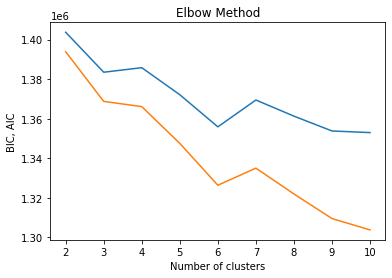

In [55]:
plt.plot(range(2, 11), bic_bow)
plt.plot(range(2, 11), aic_bow)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('BIC, AIC')
plt.show()

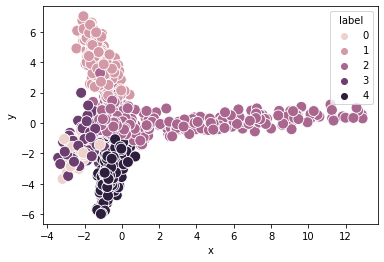

In [56]:
pred_bow = plot_em(bow, 5)

In [57]:
m_pred_bow = compare_target(pred_bow)
evaluate_model(bow, pred_bow, m_pred_bow)

the silhouette_score = 0.014784674697710123
the Kappa_score = 0.49250000000000005
the homogeneity_score = 0.8024978727880335
the coherence_score = 0.8584842596585421


###EM and TF-IDF

In [58]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

bic_tf = []
aic_tf = []
for i in range(2, 11):
  em = GaussianMixture(i, covariance_type='spherical', random_state=0).fit(DataFrame(tf_idf))
  bic_tf.append(em.bic(tf_idf))
  aic_tf.append(em.aic(tf_idf))

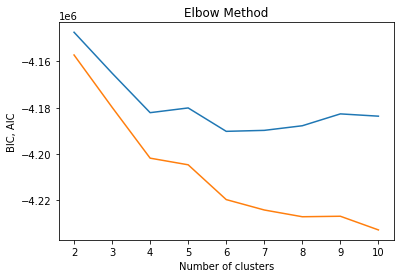

In [59]:
plt.plot(range(2, 11), bic_tf)
plt.plot(range(2, 11), aic_tf)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('BIC, AIC')
plt.show()

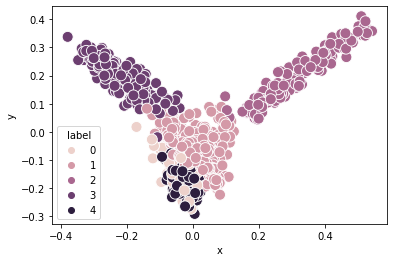

In [60]:
pred_tf = plot_em(tf_idf, 5)

In [61]:
m_pred_tf = compare_target(pred_tf)
evaluate_model(bow, pred_tf, m_pred_tf)


the silhouette_score = 0.027022483351646802
the Kappa_score = 0.31625000000000003
the homogeneity_score = 0.700481240055624
the coherence_score = 0.8895506967368878


###EM and LDA

In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

bic_lda = []
aic_lda = []
for i in range(2, 11):
  em = GaussianMixture(i, covariance_type='full', random_state=0).fit(DataFrame(lda_data))
  bic_lda.append(em.bic(lda_data))
  aic_lda.append(em.aic(lda_data))
clear_output()

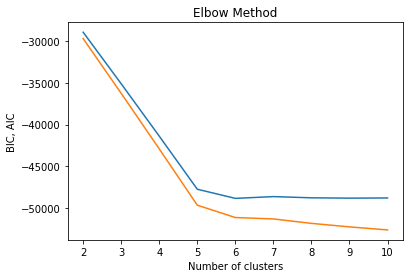

In [63]:
plt.plot(range(2, 11), bic_lda)
plt.plot(range(2, 11), aic_lda)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('BIC, AIC')
plt.show()

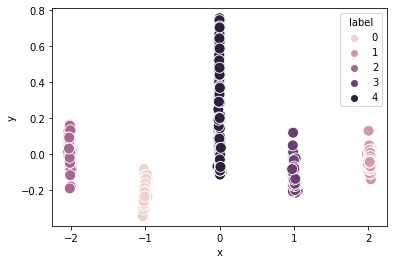

In [64]:
pred_lda = plot_em(lda_data, 5)

In [65]:
m_pred_lda = compare_target(pred_lda)
evaluate_model(bow, pred_lda, m_pred_lda)


the silhouette_score = 0.005483141597157849
the Kappa_score = 0.5
the homogeneity_score = 1.0
the coherence_score = 0.8934581901211487


###EM and Word Embedding

In [66]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

bic_we = []
aic_we = []
for i in range(1, 11):
  em = GaussianMixture(i, covariance_type='full', init_params = 'random').fit(DataFrame(we))
  bic_we.append(em.bic(we))
  aic_we.append(em.aic(we))

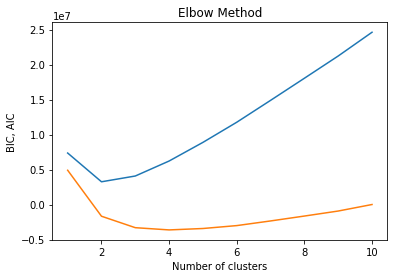

In [67]:
plt.plot(range(1, 11), bic_we)
plt.plot(range(1, 11), aic_we)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('BIC, AIC')
plt.show()

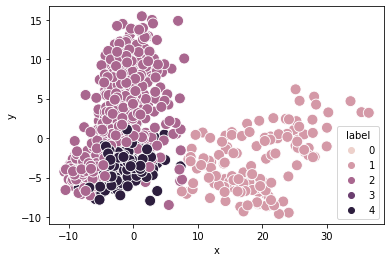

In [68]:
pred_we = plot_em(we, 5)

In [69]:
m_pred_we = compare_target(pred_we)
evaluate_model(bow, pred_we, pred_we)

the silhouette_score = -0.009174464209294573
the Kappa_score = 0.06250000000000011
the homogeneity_score = 0.4123811523335635
the coherence_score = 0.8529008443351664


##Hierarchical Cluster

In [70]:
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics import cohen_kappa_score
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import cohen_kappa_score, silhouette_score
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
!pip install plotly
import plotly.express as xpr
from sklearn.metrics.cluster import homogeneity_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):
/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.divide(0.4, 1, casting="unsafe", dtype=np.float),
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/imp

In [71]:
hc = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean', linkage = 'ward')

In [72]:
def visualize_hc_tsne(y_hc,X):
  tsne = TSNE(verbose=3,n_components=2)
  points = tsne.fit_transform(X)
  plt.scatter(points[y_hc ==0,0], points[y_hc == 0,1], s=100, c='red')
  plt.scatter(points[y_hc==1,0], points[y_hc == 1,1], s=100, c='black')
  plt.scatter(points[y_hc ==2,0], points[y_hc == 2,1], s=100, c='blue')
  plt.scatter(points[y_hc ==3,0], points[y_hc == 3,1], s=100, c='cyan')
  plt.scatter(points[y_hc ==3,0], points[y_hc == 3,1], s=100, c='yellow')

In [73]:
def visualize_hc_pca(y_hc,X):
  pca = PCA(n_components=2)
  points = pca.fit_transform(X)
  plt.scatter(points[y_hc ==0,0], points[y_hc == 0,1], s=100, c='red')
  plt.scatter(points[y_hc==1,0], points[y_hc == 1,1], s=100, c='black')
  plt.scatter(points[y_hc ==2,0], points[y_hc == 2,1], s=100, c='blue')
  plt.scatter(points[y_hc ==3,0], points[y_hc == 3,1], s=100, c='cyan')
  plt.scatter(points[y_hc ==3,0], points[y_hc == 3,1], s=100, c='yellow')

In [74]:
def plot_dendogram(data,image_name):
  #Create dendrogram
  linkage_matrix = ward(data) #define the linkage_matrix using ward clustering pre-computed distances

  fig, ax = plt.subplots(figsize=(15, 15)) # set size
  ax = dendrogram(linkage_matrix, orientation="top")

  plt.tick_params(
      axis= 'x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom='off',      # ticks along the bottom edge are off
      top='off',         # ticks along the top edge are off
      labelbottom='off')

  plt.tight_layout() #show plot with tight layout

  #uncomment below to save figure
  plt.savefig(image_name, dpi=200) #save figure as ward_clusters

In [75]:
def visualize_data(data):
  tsne = TSNE(verbose=3,n_components=2)
  x = tsne.fit_transform(data)
  sns.scatterplot(x = x[:,0], y=x[:,1], hue=df.Book_name)

In [76]:
def print_hvs(y_predict):
  y_pred = compare_target(y_predict)
  print("homogeneity_completeness_v_measure : ",homogeneity_score(df.Book_name,y_pred))

In [77]:
def plot_data_after_cluster(y_pred,x_train):
  new_df = compare_target(y_pred)
  tsne = TSNE(n_components=2,verbose=3)
  new_x = tsne.fit_transform(x_train)
  plt.figure(figsize=(15,15))
  plt.scatter(new_x[y_pred == 0,0],new_x[y_pred == 0,1],s=100,color = 'red',label = 'Book a')
  plt.scatter(new_x[y_pred == 1,0],new_x[y_pred == 1,1],s=100,color = 'blue',label = 'Book b')
  plt.scatter(new_x[y_pred == 2,0],new_x[y_pred == 2,1],s=100,color = 'yellow',label = 'Book c')
  plt.scatter(new_x[y_pred == 3,0],new_x[y_pred == 3,1],s=100,color = 'black',label = 'Book d')
  plt.scatter(new_x[y_pred == 4,0],new_x[y_pred == 4,1],s=100,color = 'green',label = 'Book e')
  plt.legend()
  plt.title("Data After Cluster")

###Choose The Best #Clusters

In [78]:
def get_best_n_cluster(data):
  #use silhouette score to get the best #clusters
  score = []
  for i in range(2,11):
    hc_cluster = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage = 'ward')
    hc_cluster.fit_predict(data)
    s = silhouette_score(data, hc_cluster.labels_, metric='euclidean')
    score.append(s)
    print('Silhouette Score: %.3f' % s)
  plt.plot(range(2,11),score)
  plt.xlabel("Number Of Clusters")
  plt.ylabel("Silhouette Score")
  plt.title("Choose The Best number Of Clusters")

###HC_BOW

In [79]:
bow_df =X_train_counts

In [80]:
bow_df=DataFrame(X_train_counts)
bow_df.dropna(inplace = True)

In [81]:
bow_df

,0,1,2,3,4,5,6,7,8,9,...,12453,12454,12455,12456,12457,12458,12459,12460,12461,12462
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


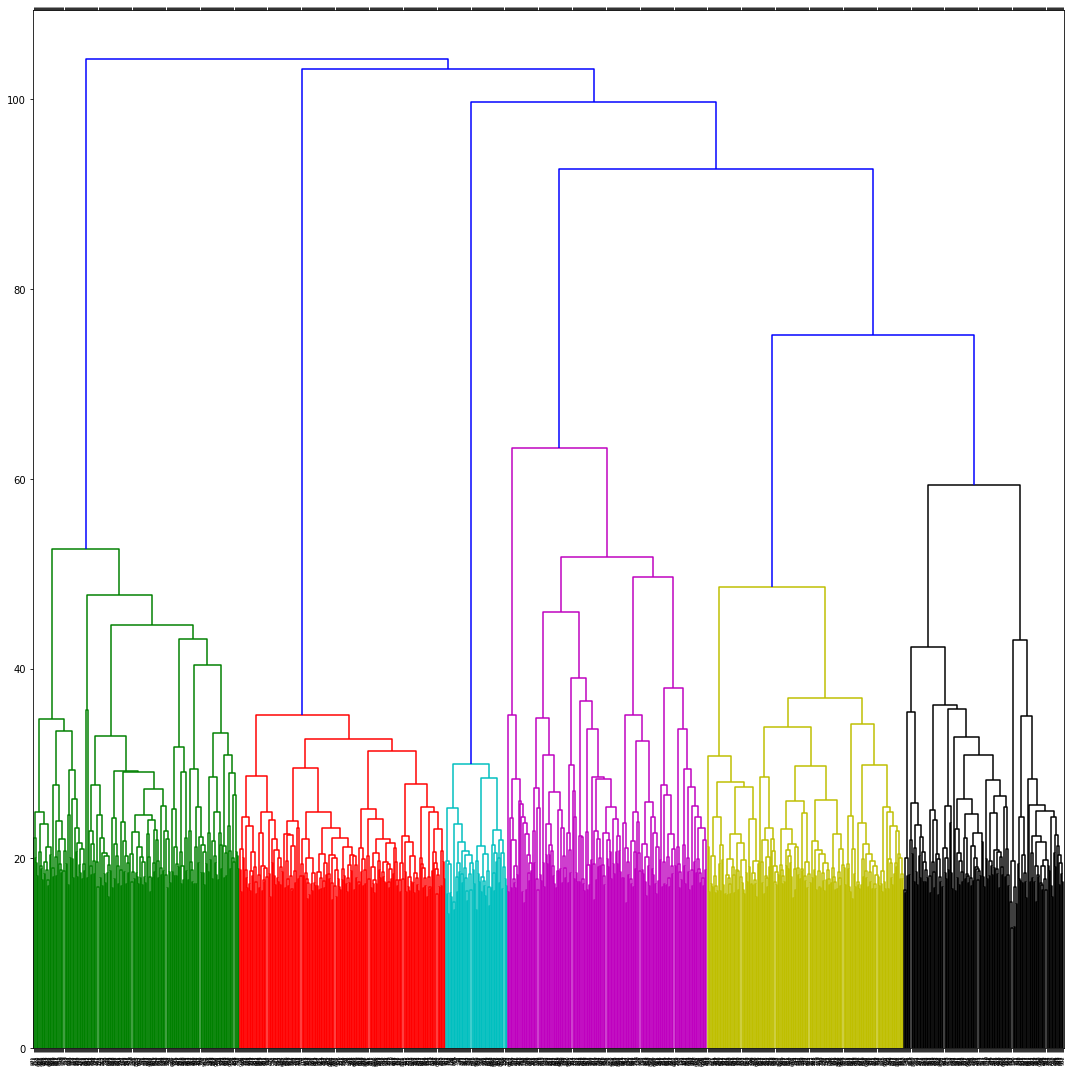

In [82]:
plot_dendogram(np.array(bow_df),"BOW_HC.png")

Silhouette Score: 0.038
Silhouette Score: 0.008
Silhouette Score: 0.016
Silhouette Score: 0.021
Silhouette Score: 0.023
Silhouette Score: 0.027
Silhouette Score: 0.030
Silhouette Score: 0.032
Silhouette Score: 0.034


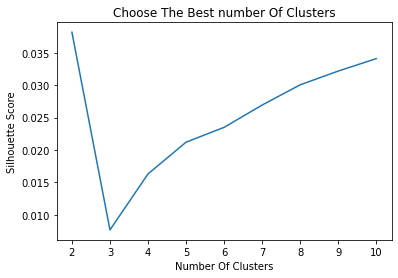

In [83]:
get_best_n_cluster(bow_df)

In [84]:
bow_y_predict_hc = hc.fit_predict(bow_df)

In [85]:
np.unique(bow_y_predict_hc, return_counts=True)

(array([0, 1, 2, 3, 4]), array([346, 194, 200,  60, 200]))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.010s...
[t-SNE] Computed neighbors for 1000 samples in 0.824s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 4.183391
[t-SNE] Computed conditional probabilities in 0.076s
[t-SNE] Iteration 50: error = 74.4856873, gradient norm = 0.3211912 (50 iterations in 0.483s)
[t-SNE] Iteration 100: error = 74.7014847, gradient norm = 0.3009306 (50 iterations in 0.465s)
[t-SNE] Iteration 150: error = 75.7801208, gradient norm = 0.3059101 (50 iterations in 0.455s)
[t-SNE] Iteration 200: error = 76.6609802, gradient norm = 0.2788102 (50 iterations in 0.508s)
[t-SNE] Iteration 250: error = 75.4318085, gradient norm = 0.2937498 (50 iterations in 0.449s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.431808
[t-SNE] Iteration 300: error = 1.2246566, gradient norm = 0.0036762 (50 iterations in 0.394s)
[t-SNE] Iteration 350: error = 1.0877588, gradient norm = 0.00072

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.011s...
[t-SNE] Computed neighbors for 1000 samples in 0.795s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 4.183391
[t-SNE] Computed conditional probabilities in 0.072s
[t-SNE] Iteration 50: error = 74.6554108, gradient norm = 0.3047890 (50 iterations in 0.437s)
[t-SNE] Iteration 100: error = 75.0278931, gradient norm = 0.2918755 (50 iterations in 0.392s)
[t-SNE] Iteration 150: error = 75.2524719, gradient norm = 0.2807928 (50 iterations in 0.401s)
[t-SNE] Iteration 200: error = 74.4123535, gradient norm = 0.3142645 (50 iterations in 0.392s)
[t-SNE] Iteration 250: error = 74.2737732, gradient norm = 0.3170709 (50 iterations in 0.382s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.273773
[t-SNE] Iteration 300: error = 1.1928365, gradient norm = 0.0035453 (50 iterations in 0.335s)
[t-SNE] Iteration 350: error = 1.0879266, gradient norm = 0.00058

Text(0.5, 0.98, "Show The Original Data Before & After Cluster [Show The Data Using DR 'PCA' && 'TSNE'] ")

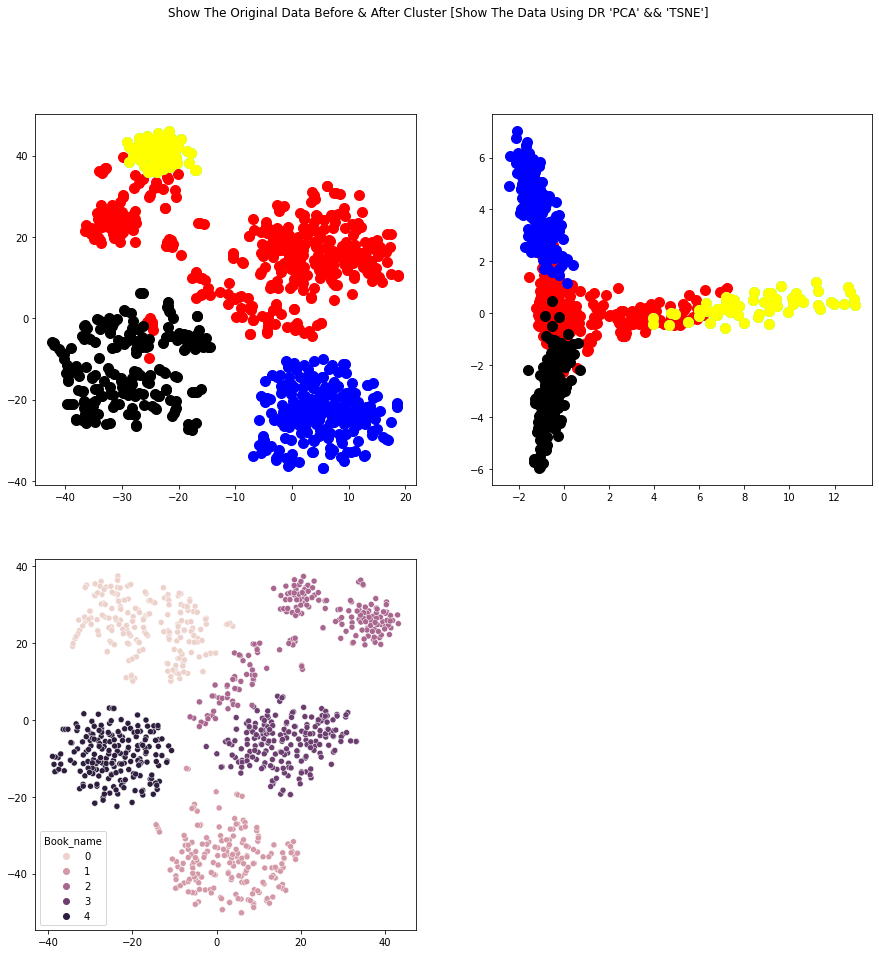

In [86]:
#Visualize data before and after cluster
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
visualize_hc_tsne(bow_y_predict_hc,bow_df)
plt.subplot(2,2,2)
visualize_hc_pca(bow_y_predict_hc,bow_df)
plt.subplot(2,2,3)
visualize_data(bow_df)
plt.suptitle("Show The Original Data Before & After Cluster [Show The Data Using DR 'PCA' && 'TSNE'] ")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.011s...
[t-SNE] Computed neighbors for 1000 samples in 0.782s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 4.183391
[t-SNE] Computed conditional probabilities in 0.074s
[t-SNE] Iteration 50: error = 73.3923874, gradient norm = 0.3187951 (50 iterations in 0.459s)
[t-SNE] Iteration 100: error = 72.3198395, gradient norm = 0.3221887 (50 iterations in 0.386s)
[t-SNE] Iteration 150: error = 74.2700500, gradient norm = 0.2991114 (50 iterations in 0.432s)
[t-SNE] Iteration 200: error = 75.0905228, gradient norm = 0.2928887 (50 iterations in 0.464s)
[t-SNE] Iteration 250: error = 75.8952637, gradient norm = 0.3021275 (50 iterations in 0.457s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.895264
[t-SNE] Iteration 300: error = 1.2296717, gradient norm = 0.0024149 (50 iterations in 0.438s)
[t-SNE] Iteration 350: error = 1.0854046, gradient norm = 0.00091

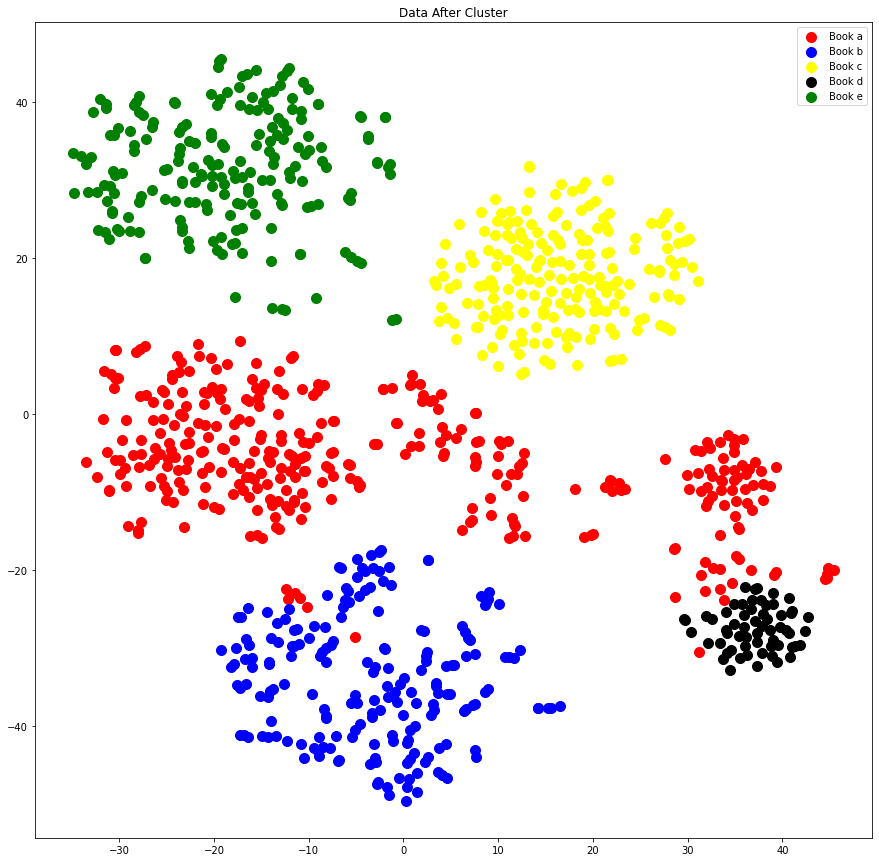

In [87]:
#Visualize Data After Cluster
plot_data_after_cluster(bow_y_predict_hc,bow_df)

In [88]:
#Calculate cohen_kappa score
tr= compare_target(bow_y_predict_hc)
bow_kappa = cohen_kappa_score(tr,df.Book_name)
print(bow_kappa)

0.25


In [89]:
#Coherance, silhouette_score and cohen_kappa score
evaluate_model(bow_df,bow_y_predict_hc,compare_target(bow_y_predict_hc))

the silhouette_score = 0.03817968425229344
the Kappa_score = 0.25
the homogeneity_score = 0.8380652991543306
the coherence_score = 0.8846961260743832


###TF-IDF HC

In [90]:
tf_df =X_train_tf

In [91]:
tf_df=DataFrame(X_train_tf)
tf_df.dropna(inplace = True)

In [92]:
tf_df

,0,1,2,3,4,5,6,7,8,9,...,12453,12454,12455,12456,12457,12458,12459,12460,12461,12462
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


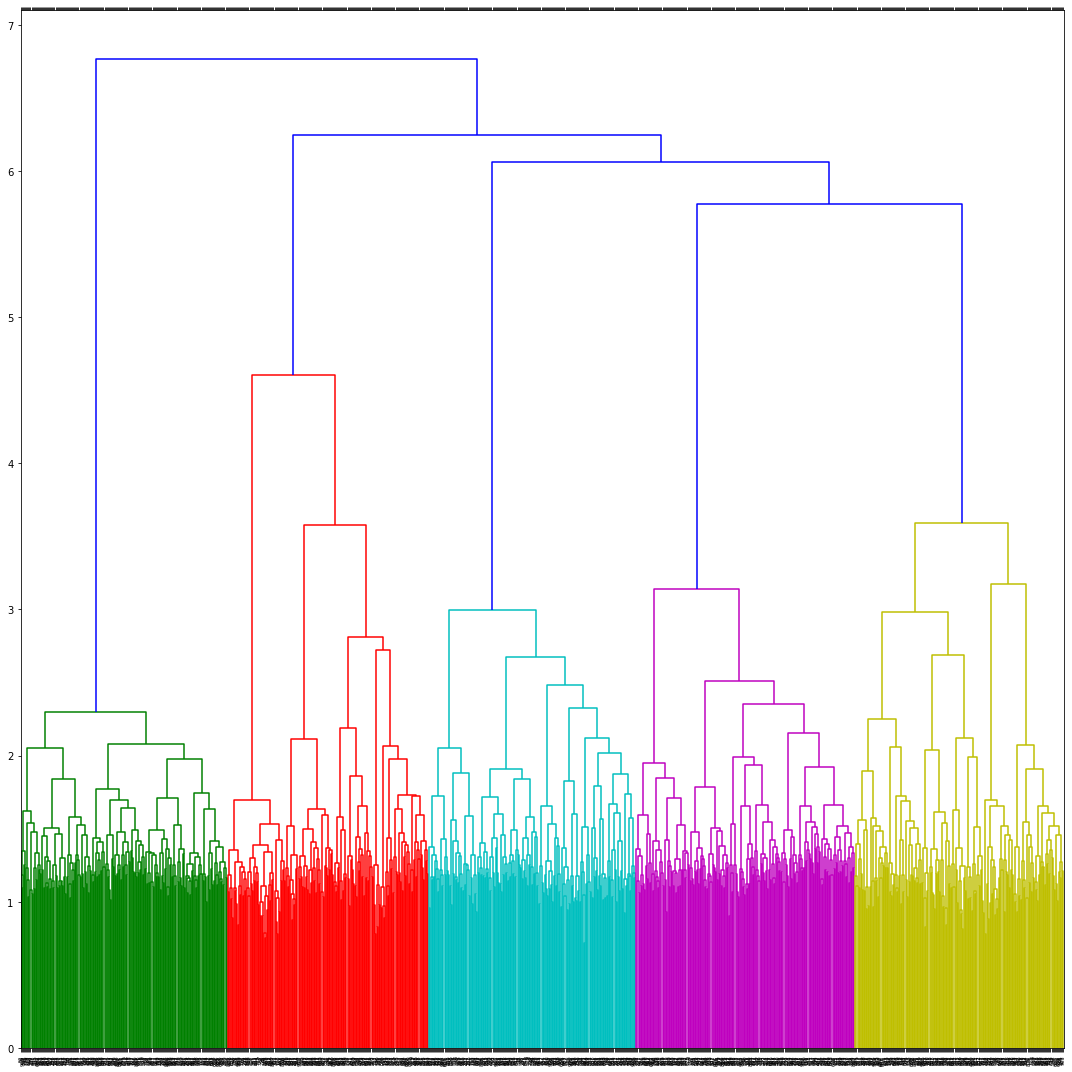

In [93]:
plot_dendogram(np.array(tf_df),"TF_HC.png")

Silhouette Score: 0.019
Silhouette Score: 0.028
Silhouette Score: 0.037
Silhouette Score: 0.044
Silhouette Score: 0.043
Silhouette Score: 0.042
Silhouette Score: 0.045
Silhouette Score: 0.046
Silhouette Score: 0.043


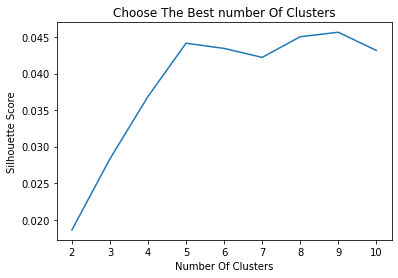

In [94]:
get_best_n_cluster(tf_df)

In [95]:
tf_y_predict_hc = hc.fit_predict(tf_df)

In [96]:
np.unique(tf_y_predict_hc, return_counts=True)

(array([0, 1, 2, 3, 4]), array([193, 210, 200, 198, 199]))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.009s...
[t-SNE] Computed neighbors for 1000 samples in 0.468s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.290115
[t-SNE] Computed conditional probabilities in 0.075s
[t-SNE] Iteration 50: error = 64.6040039, gradient norm = 0.3335282 (50 iterations in 0.387s)
[t-SNE] Iteration 100: error = 62.5574188, gradient norm = 0.2876059 (50 iterations in 0.347s)
[t-SNE] Iteration 150: error = 60.9613266, gradient norm = 0.2911899 (50 iterations in 0.316s)
[t-SNE] Iteration 200: error = 61.6024017, gradient norm = 0.2782470 (50 iterations in 0.319s)
[t-SNE] Iteration 250: error = 61.1982269, gradient norm = 0.2899768 (50 iterations in 0.351s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.198227
[t-SNE] Iteration 300: error = 1.0050880, gradient norm = 0.0032518 (50 iterations in 0.266s)
[t-SNE] Iteration 350: error = 0.8946418, gradient norm = 0.00047

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.009s...
[t-SNE] Computed neighbors for 1000 samples in 0.454s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.290115
[t-SNE] Computed conditional probabilities in 0.076s
[t-SNE] Iteration 50: error = 63.7125320, gradient norm = 0.3311598 (50 iterations in 0.384s)
[t-SNE] Iteration 100: error = 60.8050995, gradient norm = 0.2974235 (50 iterations in 0.323s)
[t-SNE] Iteration 150: error = 62.0327301, gradient norm = 0.2761334 (50 iterations in 0.337s)
[t-SNE] Iteration 200: error = 61.3146439, gradient norm = 0.2806072 (50 iterations in 0.324s)
[t-SNE] Iteration 250: error = 61.4771500, gradient norm = 0.2782559 (50 iterations in 0.333s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.477150
[t-SNE] Iteration 300: error = 1.0244088, gradient norm = 0.0023884 (50 iterations in 0.291s)
[t-SNE] Iteration 350: error = 0.9093618, gradient norm = 0.00054

Text(0.5, 0.98, "Show The Original Data Before & After Cluster [Show The Data Using DR 'PCA' && 'TSNE'] ")

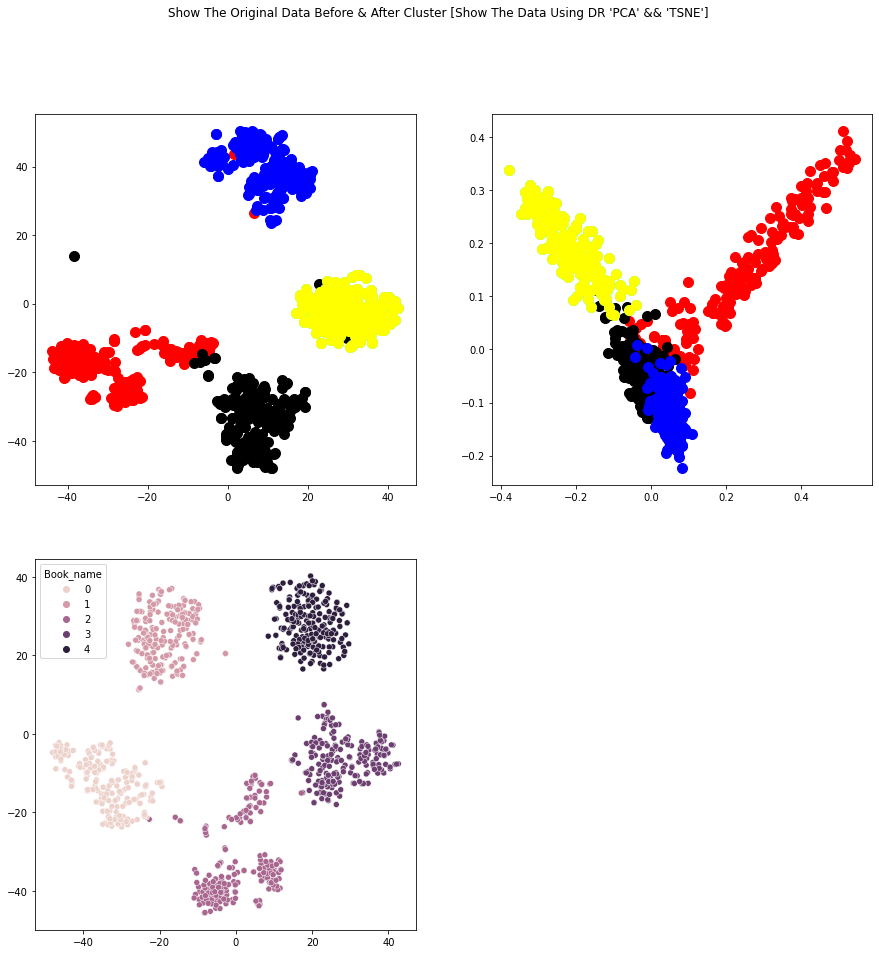

In [97]:
#Visualize data before and after cluster
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
visualize_hc_tsne(tf_y_predict_hc,tf_df)
plt.subplot(2,2,2)
visualize_hc_pca(tf_y_predict_hc,tf_df)
plt.subplot(2,2,3)
visualize_data(tf_df)
plt.suptitle("Show The Original Data Before & After Cluster [Show The Data Using DR 'PCA' && 'TSNE'] ")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.009s...
[t-SNE] Computed neighbors for 1000 samples in 0.438s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.290115
[t-SNE] Computed conditional probabilities in 0.071s
[t-SNE] Iteration 50: error = 63.6033707, gradient norm = 0.3286739 (50 iterations in 0.391s)
[t-SNE] Iteration 100: error = 61.9588928, gradient norm = 0.3005846 (50 iterations in 0.345s)
[t-SNE] Iteration 150: error = 61.2677612, gradient norm = 0.3010129 (50 iterations in 0.348s)
[t-SNE] Iteration 200: error = 62.0008392, gradient norm = 0.2799209 (50 iterations in 0.343s)
[t-SNE] Iteration 250: error = 60.6355972, gradient norm = 0.2949153 (50 iterations in 0.326s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.635597
[t-SNE] Iteration 300: error = 1.0030560, gradient norm = 0.0029599 (50 iterations in 0.282s)
[t-SNE] Iteration 350: error = 0.8898274, gradient norm = 0.00053

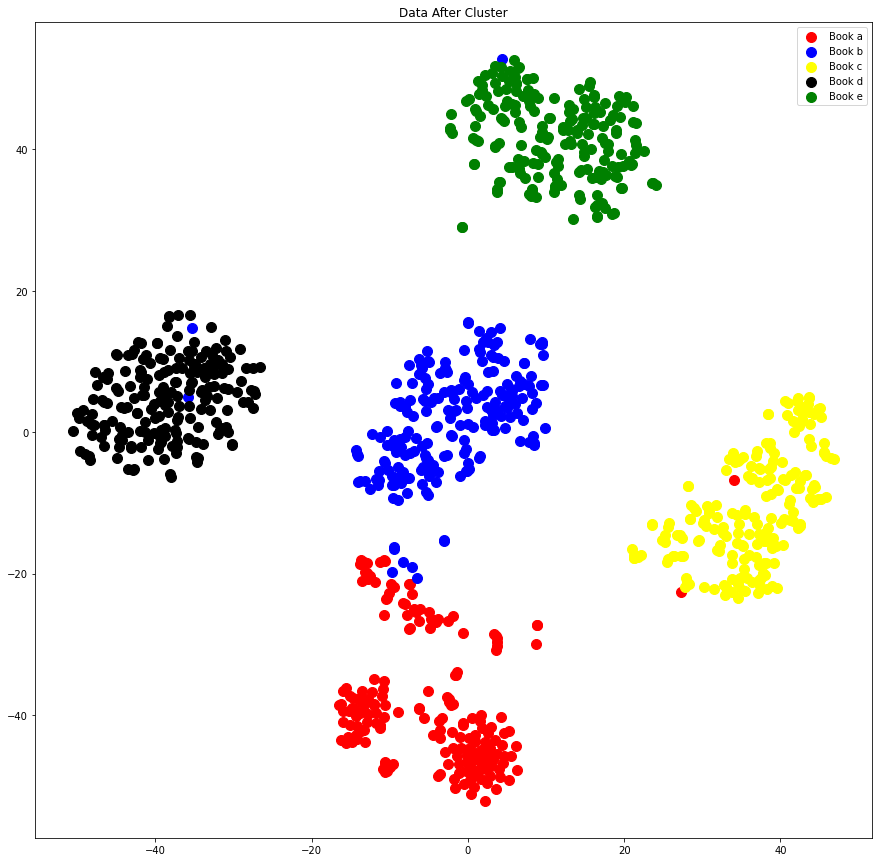

In [98]:
#Visualize Data After Cluster
plot_data_after_cluster(tf_y_predict_hc,tf_df)

In [99]:
#Calculate cohen_kappa score
tr= compare_target(tf_y_predict_hc)
tf_kappa = cohen_kappa_score(tr,df.Book_name)
print(tf_kappa)

0.24124999999999996


In [100]:
#Coherance, silhouette_score and cohen_kappa score
evaluate_model(tf_df,tf_y_predict_hc,compare_target(tf_y_predict_hc))

the silhouette_score = 0.02296504623205289
the Kappa_score = 0.24124999999999996
the homogeneity_score = 0.9700383330329128
the coherence_score = 0.8944474583236796


###LDA HC

In [101]:
lda_df = pd.DataFrame(lda_x)

In [102]:
lda_df.dropna(inplace = True)

In [103]:
lda_df

,0,1,2,3,4,5,6,7,8,9
0,0.169733,0.251762,0.011634,0.297525,0.216487,0.000662,0.008371,0.042501,0.000662,0.000662
1,0.000662,0.000662,0.000662,0.015121,0.055615,0.000662,0.000662,0.000662,0.000662,0.924628
2,0.000662,0.048710,0.352769,0.098858,0.097473,0.342730,0.000662,0.056811,0.000662,0.000662
3,0.000662,0.412373,0.000662,0.024870,0.157921,0.000662,0.308322,0.061113,0.000662,0.032750
4,0.000662,0.126147,0.784110,0.022573,0.052625,0.000662,0.000662,0.000662,0.011233,0.000662
...,...,...,...,...,...,...,...,...,...,...
995,0.022215,0.000662,0.105474,0.236268,0.107876,0.421684,0.027270,0.068999,0.008890,0.000662
996,0.015917,0.559298,0.019578,0.081398,0.122028,0.089207,0.017978,0.086367,0.007567,0.000662
997,0.015177,0.099316,0.417685,0.062594,0.289632,0.039744,0.000662,0.018364,0.046143,0.010684
998,0.007472,0.000662,0.000662,0.007808,0.043906,0.046653,0.007671,0.000662,0.651174,0.233329


In [104]:
X_train_lda = lda_df.iloc[:, :-1]
Y_train_lda = lda_df.iloc[:, -1]

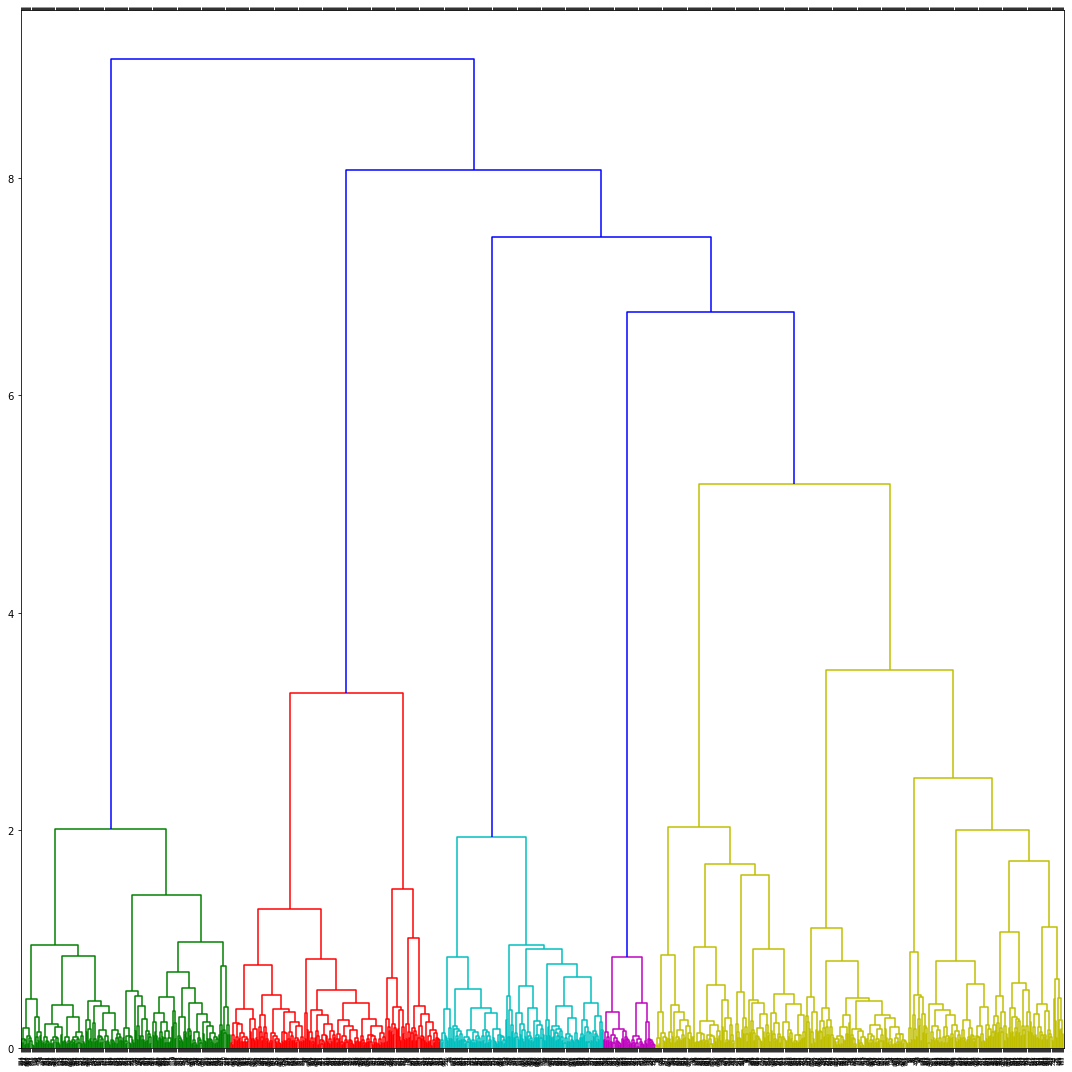

In [105]:
plot_dendogram(np.array(X_train_lda),"LDA_HC.png")

Silhouette Score: 0.259
Silhouette Score: 0.325
Silhouette Score: 0.391
Silhouette Score: 0.435
Silhouette Score: 0.429
Silhouette Score: 0.433
Silhouette Score: 0.431
Silhouette Score: 0.433
Silhouette Score: 0.418


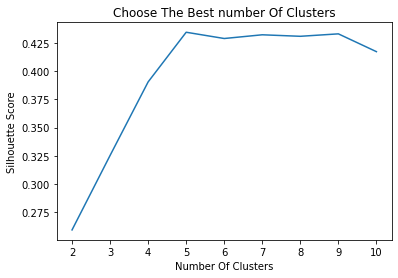

In [106]:
get_best_n_cluster(X_train_lda)

In [107]:
lda_y_predict_hc = hc.fit_predict(X_train_lda)

In [108]:
np.unique(lda_y_predict_hc, return_counts=True)

(array([0, 1, 2, 3, 4]), array([391, 201, 202, 156,  50]))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.074531
[t-SNE] Computed conditional probabilities in 0.049s
[t-SNE] Iteration 50: error = 59.0762482, gradient norm = 0.2596169 (50 iterations in 0.352s)
[t-SNE] Iteration 100: error = 55.7269897, gradient norm = 0.2180890 (50 iterations in 0.297s)
[t-SNE] Iteration 150: error = 55.1848984, gradient norm = 0.2065080 (50 iterations in 0.280s)
[t-SNE] Iteration 200: error = 54.9524155, gradient norm = 0.2183268 (50 iterations in 0.265s)
[t-SNE] Iteration 250: error = 54.6849899, gradient norm = 0.2223867 (50 iterations in 0.271s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.684990
[t-SNE] Iteration 300: error = 0.6429290, gradient norm = 0.0007139 (50 iterations in 0.257s)
[t-SNE] Iteration 350: error = 0.5625840, gradient norm = 0.00031

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Iteration 50: error = 59.4178543, gradient norm = 0.2769727 (50 iterations in 0.446s)
[t-SNE] Iteration 100: error = 56.1155014, gradient norm = 0.2106262 (50 iterations in 0.303s)
[t-SNE] Iteration 150: error = 55.5106735, gradient norm = 0.2238746 (50 iterations in 0.313s)
[t-SNE] Iteration 200: error = 55.2562332, gradient norm = 0.2213703 (50 iterations in 0.288s)
[t-SNE] Iteration 250: error = 54.9523315, gradient norm = 0.2267363 (50 iterations in 0.296s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.952332
[t-SNE] Iteration 300: error = 0.6300483, gradient norm = 0.0007260 (50 iterations in 0.261s)
[t-SNE] Iteration 350: error = 0.5487510, gradient norm = 0.0003238 (50 iterations in 0.267s)
[t-SNE] Iteration 400: error = 0.5312470, gradient norm = 0.0002024 (50 iterations in 0.272s)
[t-SNE] Iteration 450: error = 0.5221841, gradient norm = 0.0001934 (50 iterations in 0.267s)
[t-SNE] Iteration 500: error = 0.5178936, gradient norm = 0.0001489 (50 

Text(0.5, 0.98, "Show The Original Data Before & After Cluster [Show The Data Using DR 'PCA' && 'TSNE'] ")

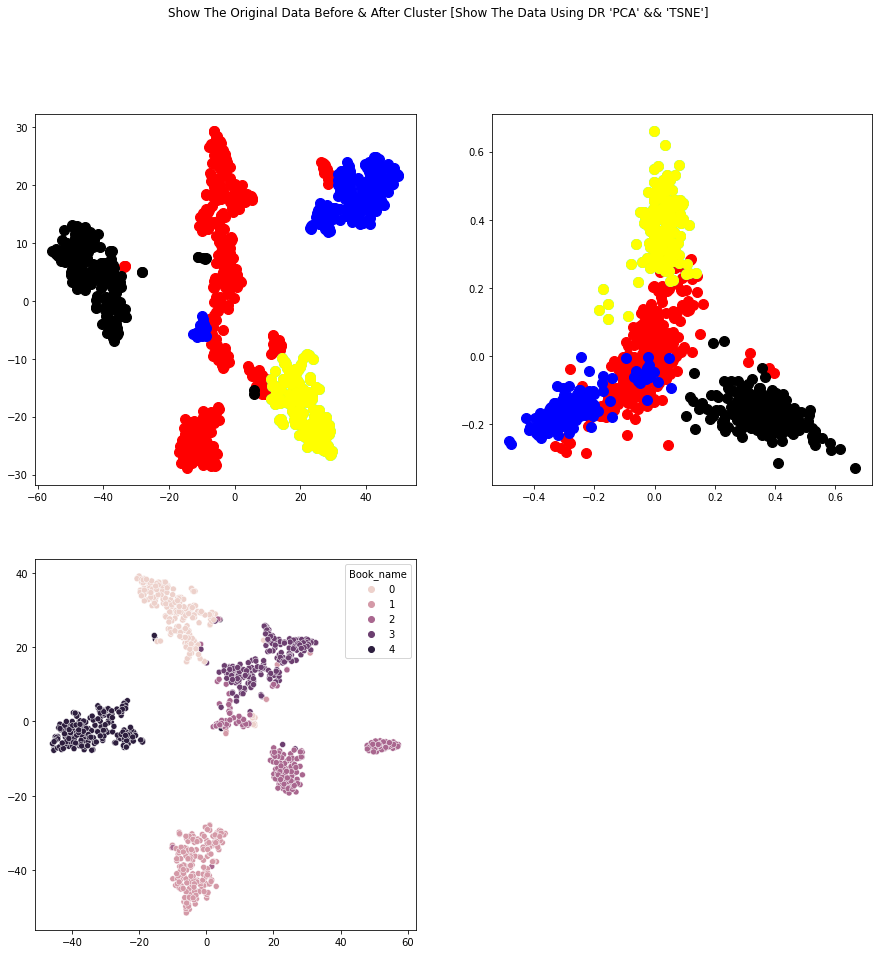

In [109]:
#Visualize data before and after cluster
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
visualize_hc_tsne(lda_y_predict_hc,X_train_lda)
plt.subplot(2,2,2)
visualize_hc_pca(lda_y_predict_hc,X_train_lda)
plt.subplot(2,2,3)
visualize_data(X_train_lda)
plt.suptitle("Show The Original Data Before & After Cluster [Show The Data Using DR 'PCA' && 'TSNE'] ")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.078837
[t-SNE] Computed conditional probabilities in 0.054s
[t-SNE] Iteration 50: error = 60.2552719, gradient norm = 0.2774629 (50 iterations in 0.396s)
[t-SNE] Iteration 100: error = 56.2978363, gradient norm = 0.2216215 (50 iterations in 0.347s)
[t-SNE] Iteration 150: error = 55.5271645, gradient norm = 0.2060611 (50 iterations in 0.304s)
[t-SNE] Iteration 200: error = 55.2161407, gradient norm = 0.2159311 (50 iterations in 0.291s)
[t-SNE] Iteration 250: error = 55.0455093, gradient norm = 0.2127120 (50 iterations in 0.278s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.045509
[t-SNE] Iteration 300: error = 0.6195363, gradient norm = 0.0006330 (50 iterations in 0.268s)
[t-SNE] Iteration 350: error = 0.5429505, gradient norm = 0.00030

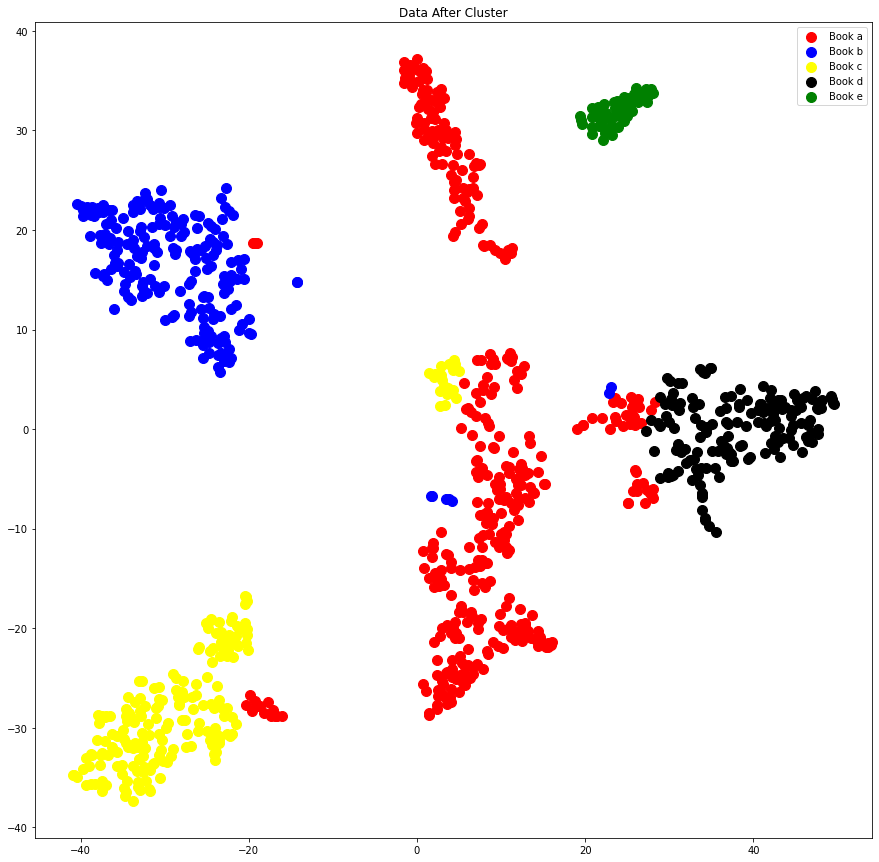

In [110]:
#Visualize Data After Cluster
plot_data_after_cluster(lda_y_predict_hc,lda_df)

In [111]:
#Calculate cohen_kappa score
tr= compare_target(lda_y_predict_hc)
lda_kappa = cohen_kappa_score(tr,df.Book_name)
print(lda_kappa)

0.24


In [112]:
#Coherance, silhouette_score and cohen_kappa score
evaluate_model(lda_df,lda_y_predict_hc,compare_target(lda_y_predict_hc))

the silhouette_score = 0.22241245210170746
the Kappa_score = 0.24
the homogeneity_score = 0.6472453085623856
the coherence_score = 0.8651223069439201


###WE HC

In [113]:
we_df =X_train_we

In [114]:
we_df=DataFrame(X_train_we)
we_df.dropna(inplace = True)

In [115]:
we_df

,0,1,2,3,4,5,6,7,8,9,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
0,-0.26173,0.583110,-0.478640,-0.172900,-0.137250,-0.113430,0.410470,0.687580,0.035578,0.132280,...,-0.289560,0.47992,-0.62933,0.145520,-1.023700,-0.193760,-0.446660,0.023420,0.266540,-0.037160
1,-0.17047,0.403700,0.210690,-0.894950,-1.097400,0.266370,-0.664380,0.434230,0.436040,-0.096505,...,-0.159540,0.18824,-0.55856,-0.282110,-0.357830,-0.136820,-0.343760,-0.339670,0.210940,0.483280
2,-0.30017,0.501450,-0.127530,-0.816380,0.336150,0.322110,-0.047370,0.037144,-0.615780,-0.223290,...,-0.484990,0.11983,0.25093,-0.096508,0.557110,-0.292820,-0.284050,-0.239780,0.044353,0.369550
3,0.45267,0.195180,0.149530,0.418520,0.748180,0.048649,0.073504,-0.269780,-0.115300,0.362250,...,0.154410,0.15045,0.42856,0.018332,0.361020,-0.342980,-0.319470,-0.649440,0.448610,-0.027693
4,-0.30226,-0.006499,0.206030,-0.009641,0.100240,0.127420,-1.070700,-0.095131,0.663770,-0.289960,...,0.660990,0.23938,-0.42688,1.245800,-1.394500,0.110160,-0.252980,-0.101230,0.178510,-0.629670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.63930,-0.963300,0.313400,0.951890,-0.548250,0.153600,-0.239170,1.006300,-0.285750,0.181010,...,-0.968050,-0.78349,-0.46458,1.002700,-1.033700,0.079409,-0.104340,0.019691,0.896480,0.102500
996,-0.02193,0.364040,0.614160,0.280650,-0.647960,0.236240,0.286630,0.181220,-0.029348,-0.015318,...,0.411970,0.11270,0.94164,0.110450,-0.702850,0.380540,0.030058,0.544800,-0.208240,0.273280
997,0.18519,0.341110,0.360970,0.270930,-0.031335,0.839230,-0.505340,-0.800620,0.406950,0.824880,...,-0.319950,0.21459,0.56411,0.435180,0.441790,0.090072,-0.030423,0.197450,1.049900,0.314190
998,-0.17032,-0.087392,-0.164540,0.088311,-0.383760,-0.126520,0.027548,-0.037083,0.539710,-0.248820,...,-0.002432,0.15247,-1.11830,-0.508490,-0.307090,-1.148100,-0.566150,0.092320,1.042400,0.350750


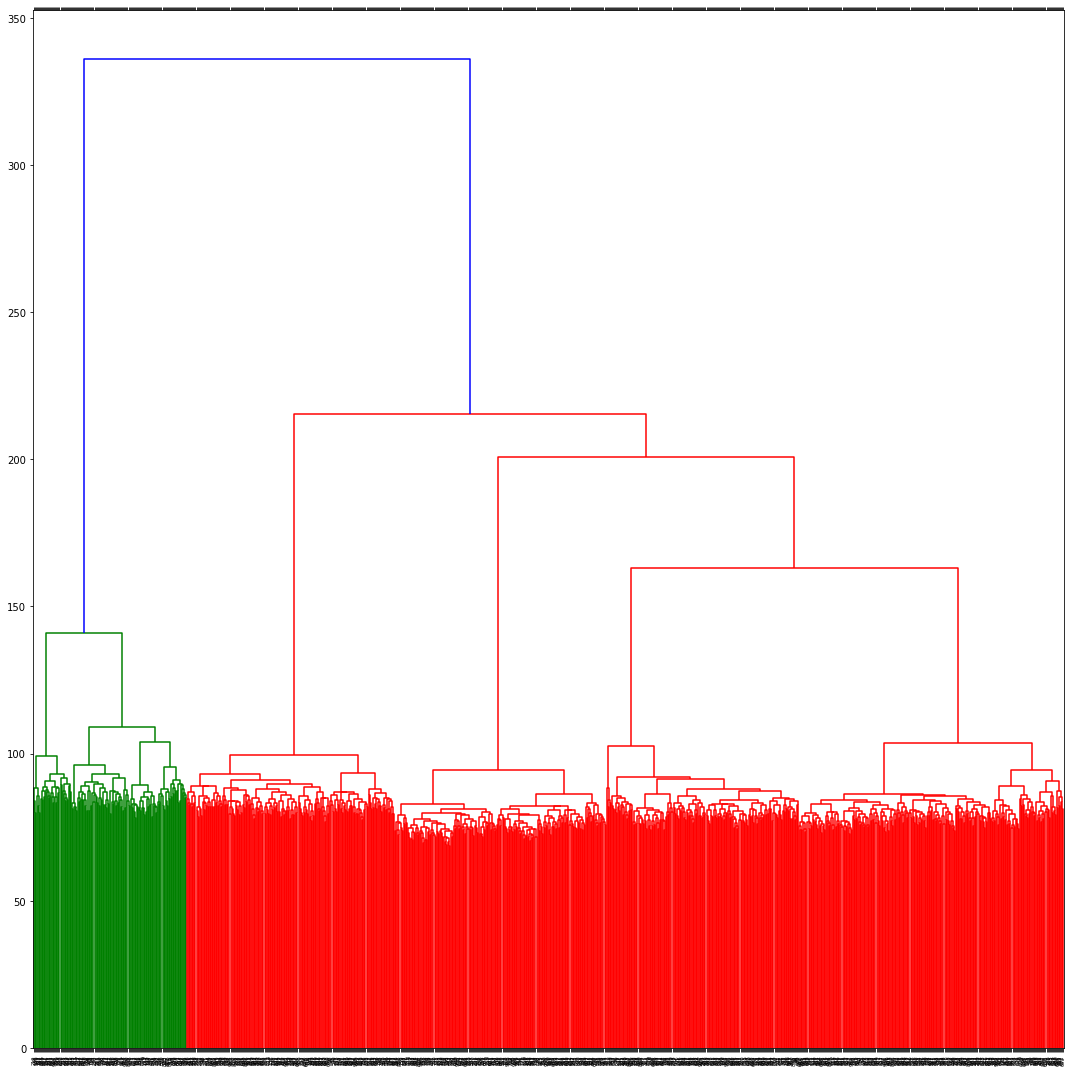

In [116]:
plot_dendogram(np.array(we_df),"WE_HC.png")

Silhouette Score: 0.054
Silhouette Score: 0.018
Silhouette Score: -0.007
Silhouette Score: -0.006
Silhouette Score: -0.005
Silhouette Score: -0.005
Silhouette Score: -0.005
Silhouette Score: -0.005
Silhouette Score: -0.005


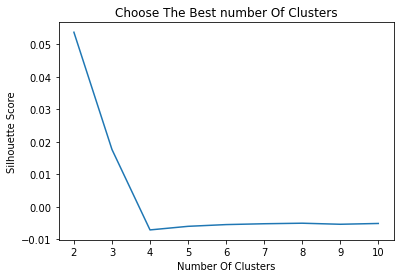

In [117]:
get_best_n_cluster(we_df)

In [118]:
we_y_predict_hc = hc.fit_predict(we_df)

In [119]:
np.unique(we_y_predict_hc, return_counts=True)

(array([0, 1, 2, 3, 4]), array([149, 257, 202, 205, 187]))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.013s...
[t-SNE] Computed neighbors for 1000 samples in 0.964s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 8.764267
[t-SNE] Computed conditional probabilities in 0.081s
[t-SNE] Iteration 50: error = 142.3506775, gradient norm = 0.1705133 (50 iterations in 0.462s)
[t-SNE] Iteration 100: error = 145.0238953, gradient norm = 0.2225609 (50 iterations in 0.436s)
[t-SNE] Iteration 150: error = 147.8409119, gradient norm = 0.1900757 (50 iterations in 0.465s)
[t-SNE] Iteration 200: error = 148.3822937, gradient norm = 0.1803566 (50 iterations in 0.423s)
[t-SNE] Iteration 250: error = 145.0183563, gradient norm = 0.1921631 (50 iterations in 0.417s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 145.018356
[t-SNE] Iteration 300: error = 4.7237158, gradient norm = 0.0033119 (50 iterations in 0.361s)
[t-SNE] Iteration 350: error = 3.0838437, gradient norm = 0

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.013s...
[t-SNE] Computed neighbors for 1000 samples in 0.939s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 8.764267
[t-SNE] Computed conditional probabilities in 0.092s
[t-SNE] Iteration 50: error = 142.0960388, gradient norm = 0.2580038 (50 iterations in 0.443s)
[t-SNE] Iteration 100: error = 140.3855286, gradient norm = 0.2463241 (50 iterations in 0.483s)
[t-SNE] Iteration 150: error = 148.0960083, gradient norm = 0.1986716 (50 iterations in 0.401s)
[t-SNE] Iteration 200: error = 153.8338623, gradient norm = 0.1806647 (50 iterations in 0.457s)
[t-SNE] Iteration 250: error = 160.6598206, gradient norm = 0.1592788 (50 iterations in 0.425s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 160.659821
[t-SNE] Iteration 300: error = 6.2588315, gradient norm = 0.0029361 (50 iterations in 0.407s)
[t-SNE] Iteration 350: error = 5.5084629, gradient norm = 0

Text(0.5, 0.98, "Show The Original Data Before & After Cluster [Show The Data Using DR 'PCA' && 'TSNE'] ")

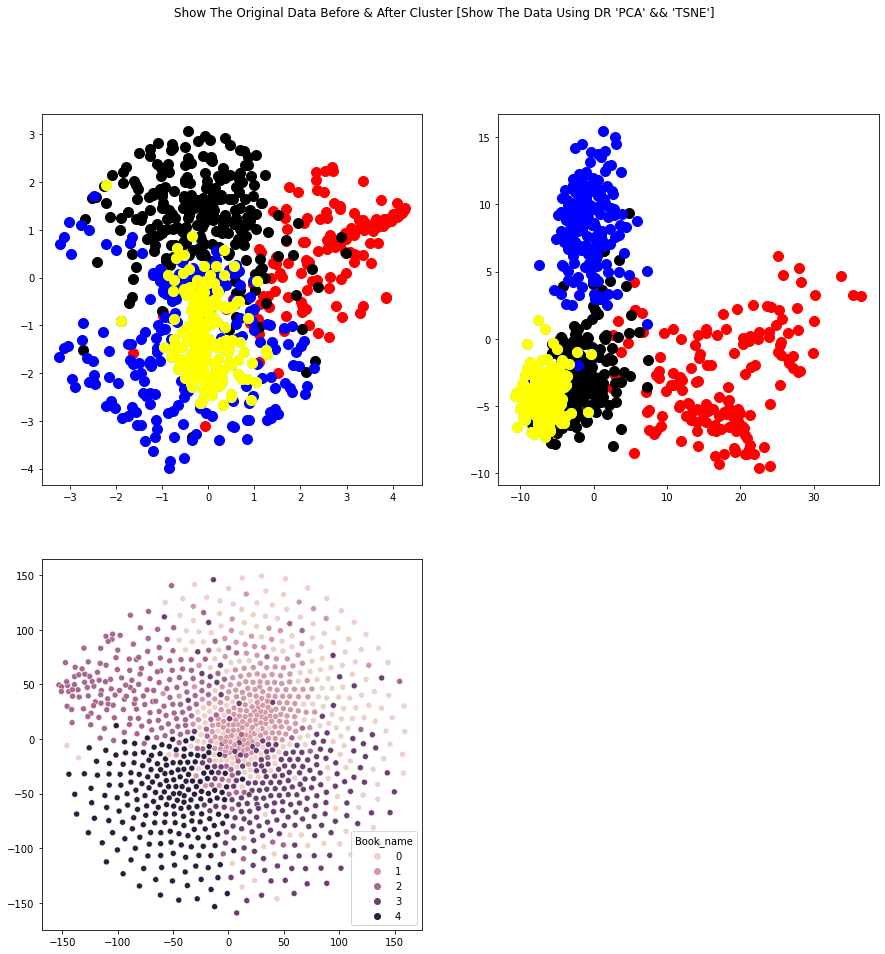

In [120]:
#Visualize data before and after cluster
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
visualize_hc_tsne(we_y_predict_hc,we_df)
plt.subplot(2,2,2)
visualize_hc_pca(we_y_predict_hc,we_df)
plt.subplot(2,2,3)
visualize_data(we_df)
plt.suptitle("Show The Original Data Before & After Cluster [Show The Data Using DR 'PCA' && 'TSNE'] ")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.013s...
[t-SNE] Computed neighbors for 1000 samples in 0.983s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 8.764267
[t-SNE] Computed conditional probabilities in 0.086s
[t-SNE] Iteration 50: error = 140.8373413, gradient norm = 0.2091896 (50 iterations in 0.576s)
[t-SNE] Iteration 100: error = 142.1549988, gradient norm = 0.1939468 (50 iterations in 0.487s)
[t-SNE] Iteration 150: error = 139.0395508, gradient norm = 0.2026829 (50 iterations in 0.409s)
[t-SNE] Iteration 200: error = 155.0487823, gradient norm = 0.1456767 (50 iterations in 0.416s)
[t-SNE] Iteration 250: error = 148.3940582, gradient norm = 0.1946324 (50 iterations in 0.411s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 148.394058
[t-SNE] Iteration 300: error = 4.9744692, gradient norm = 0.0029103 (50 iterations in 0.362s)
[t-SNE] Iteration 350: error = 4.4587784, gradient norm = 0

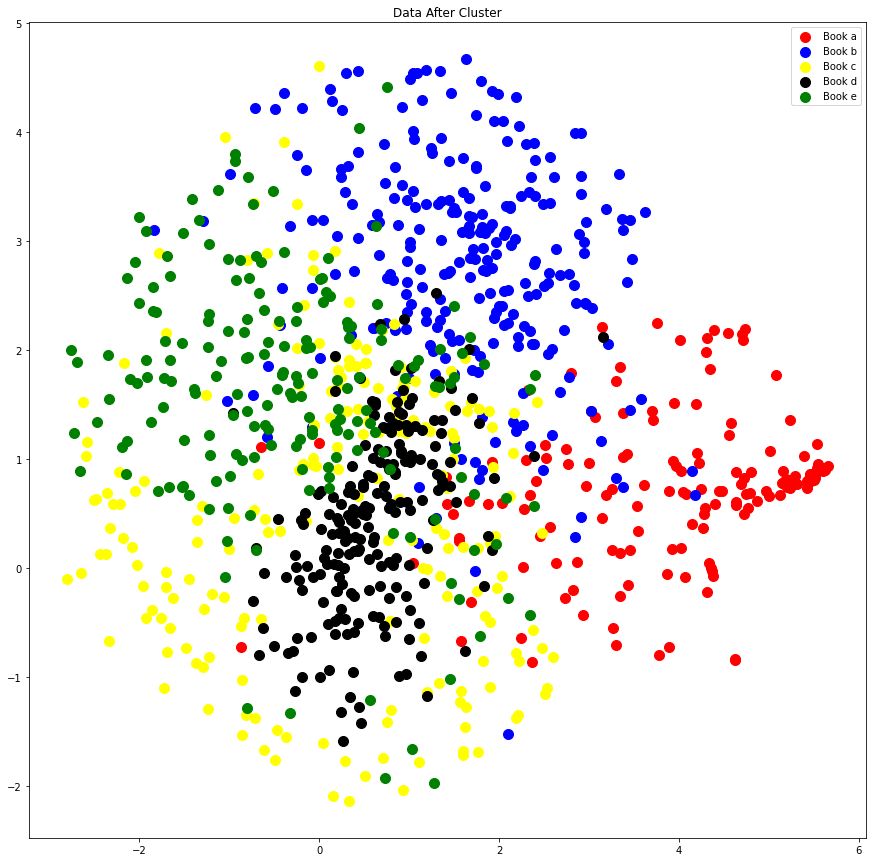

In [121]:
#Visualize Data After Cluster
plot_data_after_cluster(we_y_predict_hc,we_df)

In [122]:
#Calculate cohen_kappa score
tr= compare_target(we_y_predict_hc)
we_kappa = cohen_kappa_score(tr,df.Book_name)
print(we_kappa)

0.405


In [123]:
#Coherance, silhouette_score and cohen_kappa score
evaluate_model(we_df,we_y_predict_hc,compare_target(we_y_predict_hc))

the silhouette_score = -0.0030253506265580654
the Kappa_score = 0.40500000000000014
the homogeneity_score = 0.7765033100394206
the coherence_score = 0.8986079620060167


###My Champion Model

In [124]:
x = ["BOW", "TF-IDF", "LDA", "WE"]
y = [bow_kappa, tf_kappa, lda_kappa, we_kappa]
xpr.bar(x = x, y=y, labels={"x":"Feature Extraction Techniques","y":"Kappa Score"},color=y)

#Visualizations:

/usr/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

/usr/local/lib/python3.7/dist-packages/wordcloud/wordcloud.py:30: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>



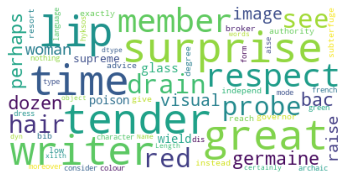

In [125]:
import wordcloud
import matplotlib.pyplot as plt
wc=wordcloud.WordCloud(background_color='white',max_words=100,max_font_size=50)
wc=wc.generate(str(df['words']))
fig=plt.figure(num=1)
plt.axis('off')
plt.imshow(wc,cmap=None)
plt.show()

<Figure size 432x288 with 0 Axes>

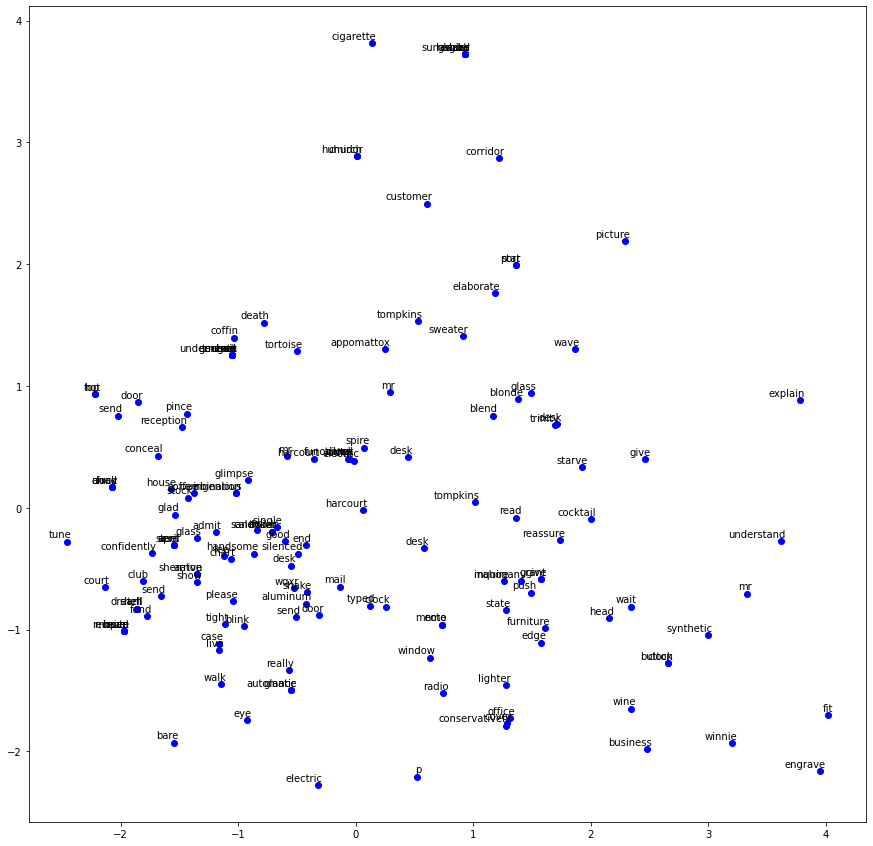

In [126]:
#Word Embedding:

doc2vec = nlp[df['words'].iloc[0]]
# pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
pca = decomposition.PCA(n_components=2)
reduction = pca.fit_transform(doc2vec)
reduction.shape

labels, X, x, y = [], [], [], []
for value in reduction:
    x.append(value[0])
    y.append(value[1])
## plot

for t in range(0, 150):
    X.append(reduction[t])
    labels.append(df['words'].iloc[5][t])

fig = plt.figure()
plt.figure(figsize=(15,15))
for i in range(len(x)):
    plt.scatter(x[i], y[i], c="blue")
    
    plt.annotate(labels[i], 
                 xy=(x[i],y[i]), 
                 xytext=(5,2), 
               textcoords='offset points', ha='right', va='bottom')

In [127]:
%pip install pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda1, bow_, dictionary=dictionary)
vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 8.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=3b50304766ce1523bd2d7e5d7d0cbb879250e54d9b5061b260e8fcfde0654a6a
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/google/colab/_pip.py:87: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/funcy-1.17.dist-info/top_level.txt' mode='r' encoding='UTF-8'>

/usr/local/lib/python3.7/dist-packages/google/colab/_pip.py:87: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/pyLDAvis-3.3.1.dist-info/top_level.txt' mode='r' encoding='UTF-8'>

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.191910  0.061384       1        1  19.650509
3     -0.099074 -0.072921       2        1  15.640052
1     -0.193849  0.010614       3        1  13.431176
5     -0.077569  0.049288       4        1  10.813638
2     -0.040110 -0.080052       5        1   9.795286
9      0.103867  0.238527       6        1   8.485260
7     -0.045260  0.034518       7        1   7.556947
8      0.261961  0.127894       8        1   6.913774
0      0.119869 -0.245368       9        1   5.698191
6      0.162076 -0.123883      10        1   2.015169, topic_info=          Term        Freq       Total Category  logprob  loglift
464       king  352.000000  352.000000  Default  30.0000  30.0000
310       tell  436.000000  436.000000  Default  29.0000  29.0000
301        say  743.000000  743.000000  Default  28.0000  28.0000
76       music  394.000000  394.000000  Default  27.0000  27.0000
194       soup  293.000000  293.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
450    example   12.396243   30.250886  Topic10  -5.4965   3.0123
370       lady   14.324188  122.996770  Topic10  -5.3520   1.7543
1729  mountain   12.293984   39.315055  Topic10  -5.5048   2.7420
389      raise   11.917323   50.930145  Topic10  -5.5359   2.4520
1132       arm   11.703832   51.633604  Topic10  -5.5540   2.4202

[591 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         2  0.977297  ability
2191      5  0.993346   abydos
810       1  0.995137  account
1283      3  0.976698   action
1283      7  0.014363   action
...     ...       ...      ...
118       3  0.612355      yet
1595      1  0.094597    young
1595      2  0.796195    young
1595      8  0.102480    young
2404      2  0.991474        z

[1019 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 6, 3, 10, 8, 9, 1, 7])